# Recording a Dissociation Curve for H$_2$: RHF vs. UHF

In this exercise you will calculate the dissociation curve for the H$_2$ molecule. So far, we focused on the choice of the basis set and on the effect of the basis set size. However, together with the choice of the basis set, another fundamental choice in computational chemistry calculations is what computational method will give you the most accurate results (in a reasonable time). In this exercise you will be introduced to two similar methods, both related to Hartree-Fock (HF) method: **Restricted HF (RHF)** and **Unrestricted HF (UHF)**.

First again we again import the required modules:

In [1]:
import psi4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from helpers import *

then we set the maximum ressources that can be used

In [2]:
psi4.set_memory('2 GB')
psi4.set_num_threads(4)


  Memory set to   1.863 GiB by Python driver.
  Threads set to 4 by Python driver.


We want to calculate the energy of H$_2$ at the following internuclear distances at
both the RHF/6-31G and UHF/6-31G level of theory, i.e. we use two different energy methods with the same basis set. 

You are given the example for RHF and you need to modify the UHF calculation. 

The calcuation works by creating a list of the distances we want to try and then by iterating over it:
* we create a `h2` molecule replacing the z coordinate in the XYZ matrix with our desired distance. 
* we specify the logfile and set appending to `True`
* we specify the reference we want to use and set
    * for the guess in the RHF calculation: `'guess_mix':False` and `'guess':'sad'` 
    * for the guess in the UHF calculation: `'guess_mix':True` and `'guess':'gwh'` 
* we use `psi4.energy` specificing the desired method (i.e. RHF or UHF), basis and molecule
* we clean up temporary files and add our calculated energy to a list for the plotting


In [10]:
# we provide the example for the RHF case. Run this cell and copy it below, adapting it to the UHF case
psi4.core.clean_options()
psi4.core.clean()

distances = [0.50,0.60,0.80,1.00,1.50,2.50,4.00, 5.00, 6.00] # distances along which we will record the dissociation curve
                                                             # For each distance, a single point energy calculation is performed
energies_RHF = [] 
print(f'R(Å) |  E_RHF [a.u]')
print( '-----|-------------')
      
for dist in distances:
    h2 = psi4.geometry(f"""
    0 1
    symmetry c1
    H 0.0 0.0 0.0
    H 0.0 0.0 {dist} 
    """) # for each iteration, we define a new h2 molecule, changing the z coordinate of the second H atom 
 
    psi4.core.set_output_file(f'dissociationcurve_RHF.log', True)
    psi4.set_options({'reference':'rhf', 'guess_mix': "False", 'guess':'sad'})
    E_RHF = psi4.energy('hf/6-31G', molecule=h2)

    print(f'{dist}  | {E_RHF:.3f}')

    energies_RHF.append(E_RHF)

R(Å) |  E_RHF [a.u]
-----|-------------
0.5  | -1.058
0.6  | -1.110
0.8  | -1.124
1.0  | -1.095
1.5  | -0.998
2.5  | -0.857
4.0  | -0.770
5.0  | -0.751
6.0  | -0.742


In [16]:
# perform another set of calculations, now using UHF
# copy and adapt the above cell here
# remember to update the method and also the guess and guess_mix options as explained above! 
psi4.core.clean_options()
psi4.core.clean()

distances = [0.50,0.60,0.80,1.00,1.50,2.50,4.00, 5.00, 6.00] # distances along which we will record the dissociation curve
                                                             # For each distance, a single point energy calculation is performed
energies_UHF = [] 
print(f'R(Å) |  E_UHF [a.u]')
print( '-----|-------------')
      
for dist in distances:
    h2 = psi4.geometry(f"""
    0 1
    symmetry c1
    H 0.0 0.0 0.0
    H 0.0 0.0 {dist} 
    """) # for each iteration, we define a new h2 molecule, changing the z coordinate of the second H atom 
 
    psi4.core.set_output_file(f'dissociationcurve_UHF.log', True)
    psi4.set_options({'reference':'uhf', 'guess_mix': "True", 'guess':'gwh'})
    E_UHF = psi4.energy('hf/6-31G', molecule=h2)

    print(f'{dist}  | {E_UHF:.3f}')

    energies_UHF.append(E_UHF)

R(Å) |  E_UHF [a.u]
-----|-------------
0.5  | -1.058
0.6  | -1.110
0.8  | -1.124
1.0  | -1.095
1.5  | -1.019
2.5  | -0.997
4.0  | -0.996
5.0  | -0.996
6.0  | -0.996


Now we want to plot the interaction energy against the interatomic distance, where for a given distance $\mathbf{R}$, the interaction energy $E_{inter}(\mathbf{R})$ can be calculated as:

$$
\begin{aligned}
          E_{inter}^{6-31G}(\mathbf{R}) = E_{H_2}^{6-31G}(\mathbf{R})-2\cdot E_H^{6-31G}
          \end{aligned}
$$

We need the value of the hydrogen atom $E_H^{6-31G}$. In particular, we will use as reference value for the H atom the UHF one. This is because RHF method for closed-shell singlet systems, which is not the case for a single H atom.



In [17]:
psi4.core.clean_options()
psi4.core.clean()

h = psi4.geometry(f"""
0 2
H 0.0 0.0 0.0
""")
psi4.set_options({'reference':'uhf'})
psi4.core.set_output_file(f'single_UHF.log', True)
E_H_UHF = psi4.energy('hf/6-31G', molecule=h)

E_H_UHF

-0.49823291072906983

We would like to can convert our lists of energies from Hartree to  kcal mol$^{-1}$ to interpret easily the results. Psi4 comes with a handy set of [conversion factors](https://psicode.org/psi4manual/master/autodoc_physconst.html) e.g to convert a.u into kcal mol$^{-1}$

In [18]:
psi4.constants.hartree2kcalmol

627.5094737775374

We can convert the list of energies to numpy arrays and use broadcasting to quickly substract the energy of the single H atoms from each list item to get the interaction energy. 

We have to use `np.array` as standard python lists (defined using `[item1, item2]`) do not support broadcasting. 
Broadcasting is an efficient way to perform arithmetics on vectors and matrices in python. Instead of having to write a for loop to perform aritemethic for each element we can simply substract the single H energy and conver to kcal mol$^{-1}$ once and the operation is broadcast. 

In [19]:
#Complete the interaction energy

E_inter_RHF = (np.array(energies_RHF) - 2 * E_H_UHF) * psi4.constants.hartree2kcalmol

E_inter_UHF = (np.array(energies_UHF) - 2 * E_H_UHF) * psi4.constants.hartree2kcalmol

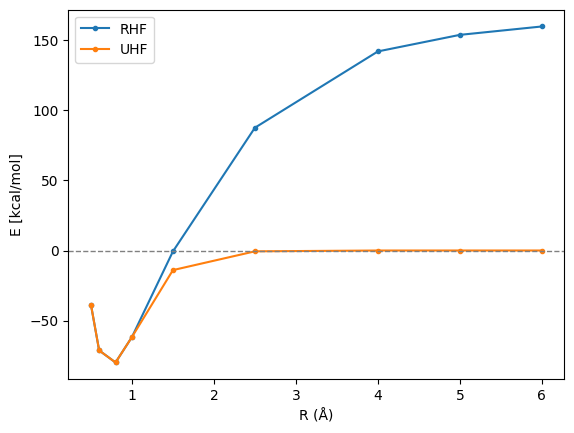

In [20]:
fig, ax = plt.subplots(1)

ax.plot(distances,E_inter_RHF, '.-', label='RHF')
ax.plot(distances,E_inter_UHF, '.-', label='UHF')

ax.axhline(0, color='gray', lw=1, linestyle='--')

ax.set_xlabel('R (Å)')
ax.set_ylabel('E [kcal/mol]')
ax.legend()
plt.show()

```{admonition} Exercise 4
:class: exercise
Explain the physical origin of the difference between the two
    dissociation curves. Discuss how important this difference is by
    comparing to the energy that is normally required to break a bond.
```

```{admonition} Exercise 5 - Bonus
:class: exercise
Try to find out why we are using `guess_mix:True` and `'guess':'gwh'`. **Hint**: What happend if you use the same settings as for the RHF calculation?

You can also look at the Psi4 manual to find out about the different options for the initial guess. 
```

